# App sales analysis and customer segmentation
<a id='top'></a>
## Table of Contents
1. [Schema and tables](#section-1)
2. [Report: Sales and DAU Analysis](#section-2)
    1. [Analysis of the daily active users: Code and Visualizations](#subsection-2.1)
    2. [Analysis of the daily active users: Comments](#subsection-2.2)
    3. [Sales analysis: Code and visualizations](#subsection-2.3)
    4. [Sales analysis: Comments](#subsection-2.4) 
3. [Behavioral segmentation model](#section-3)
    1. [Customer segmentation with FRM: Comments](#subsection-3.1) 

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  25 15:44:34 2023
@author: sara-
Concept: EDA on a SQLite Dabatabase sample.sqlite
"""
# Basics
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime
import csv

from sklearn.cluster import KMeans

# Visualizations
import matplotlib.pyplot as plt
import pygal 
from mpl_toolkits.mplot3d import Axes3D


PATH = r""
COUNTRY_CODES_PATH = r'country_codes.csv'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Create connexion and cursor
cnx = sqlite3.connect(PATH)
cur = cnx.cursor()

# Show a list of all available tables in SQLite db
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
print(table_list)

[('account',), ('iap_purchase',), ('account_date_session',), ('country_mappings',), ('country_coordinates',)]


<a id='section-1'></a>
## Schema and tables 
There are 3 tables that contain the following information:

<ul>
  <li><b>Table account:</b> contains all the information of each user profile referenced by account_id with a shape of (112792, 6)</li>
  <li><b>Table iap_purchase:</b> contains all the transactions made in app purchase with a shape of (9909, 5)</li>
  <li><b>Table account_date_session</b> contains all the logins and session duration by account_id with a shape of (1698974, 4)</li>
</ul>
<br>

The columns are pretty self-explanatory and are the following:

<b>account_id:</b> unique user identifier (in all 3 tables)

### account


<ul>
  <li><b>created_time: </b>timestamp of when the user has created his/her profile</li>
  <li><b>created_platform: </b>user's platform (either iOS or Android)</li>
  <li><b>country_code: </b>2-letter ISO2 CODE identifier for eachh country</li>
  <li><b>created_app_store_id: </b> app id from where the user account has been created</li>
</ul>

### account_date_session
<ul>
  <li><b>date: </b>date in a YYYY-MM-DD that the user has logged in</li>
  <li><b>session_count: </b>times the user has used the app in in a day</li>
  <li><b>session_duration_sec: </b>duration in seconds of each session</li>
</ul>

### iap_purchase

<ul>
  <li><b>created_time: </b>timestamp of the purchase</li>
  <li><b>package_id_hash: </b>unique identifier for each package available for purchase</li>
  <li><b>iap_price_usd_cents: </b>total spent on the purchase in dollar cents</li>
  <li><b>app_store_id: </b>unique identifier for each app</li>
</ul>

<img src='images\fig_1.png'>

The table account has a unique non null column which is a perfect candidate for a primary key: account_id. The number of unique values in a table can be checked in the following way:
~~~sql
SELECT COUNT(DISTINCT account_id) AS unique_values_count
FROM account_date_session;
~~~

For the tables 'iap_purchase and 'account_date_session', I would create a unique purchase and session ID respectively. In those tables, account_id would be considered the foreign key and it would have a relationship of many to one.

~~~sql
ALTER TABLE account
ADD PRIMARY KEY (account_id);

ALTER TABLE iap_purchase
ADD COLUMN purchase_id INT PRIMARY KEY AUTO_INCREMENT;

ALTER TABLE iap_purchase
ADD CONSTRAINT fk_iap_purchase_account
FOREIGN KEY (account_id) REFERENCES account(account_id);

-- repeat sql queries for account_date_session table
~~~

There are multiple schemas that could be implemented for this database. Personally, I would choose star schema. The account_date_session or the iap_purchase would be candidates to be a FACT table because they contain the primary business metrics while accounts would be a DIMENSION table which contains descriptive attributes.

<a id='section-2'></a>

## Report: Sales and DAU Analysis
In this section, the python code used to create the visualizations is combined with the analysis commentaries. However, another option for those visualizations would be to create interactive dashboards with PowerBI or Tableau. In that way filters, KPIs and charts could be shown together in the same report.

<a id='subsection-2.1'></a>
### Analysis of the daily active users: Code and Visualizations

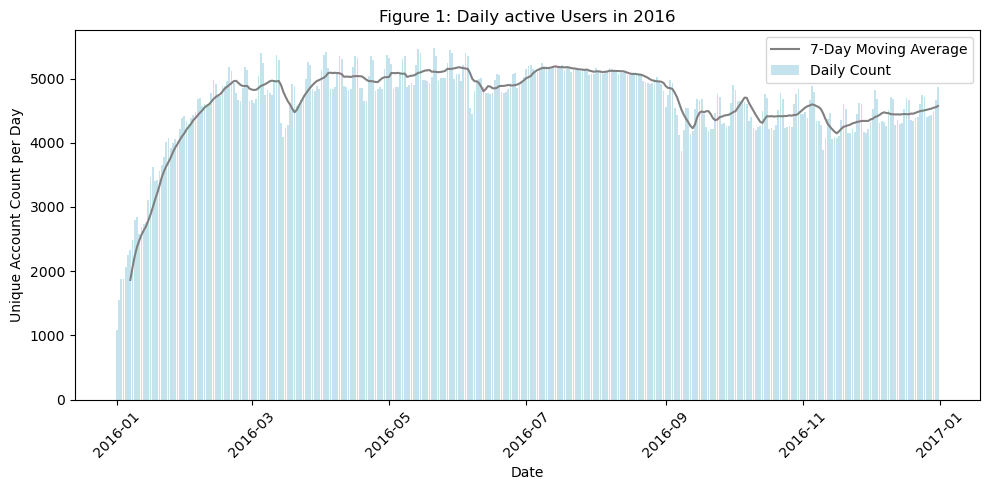

In [75]:
cur.execute('''
    SELECT date, COUNT(DISTINCT account_id) AS unique_account_count
    FROM account_date_session
    GROUP BY date;
''')
dau_day_data = cur.fetchall()
dates, counts_day = zip(*dau_day_data)

# Convert dates to datetime objects
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Avg per day
average_per_day = [count for count in counts_day]

# Calculate moving average with a 7 day window
window_size = 7
moving_average = np.convolve(average_per_day, np.ones(window_size)/window_size, mode='valid')

# Adjust dates to match the moving average
moving_average_dates = dates[window_size-1:]

# Visualize the data and moving average
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(dates, average_per_day, color='lightblue', alpha=0.7, label='Daily Count')
ax.plot(moving_average_dates, moving_average, color='gray', label=f'{window_size}-Day Moving Average')

ax.set_xlabel('Date')
ax.set_ylabel('Unique Account Count per Day')
ax.set_title('Figure 1: Daily active Users in 2016')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

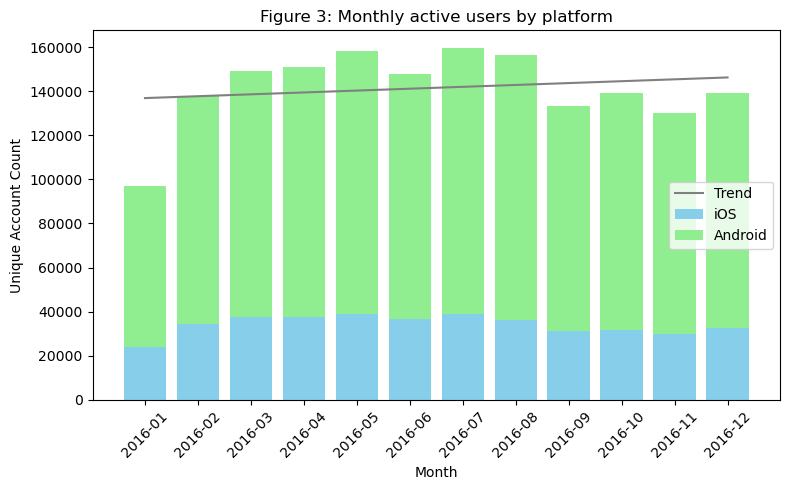

In [5]:
import matplotlib.pyplot as plt

cur.execute('''
SELECT
    strftime('%Y-%m', ads.date) AS month,
    COUNT(DISTINCT a.account_id) AS unique_account_count,
    SUM(CASE WHEN a.created_platform = 'iOS' THEN 1 ELSE 0 END) AS unique_ios_account_count,
    SUM(CASE WHEN a.created_platform = 'Android' THEN 1 ELSE 0 END) AS unique_android_account_count
FROM
    account_date_session as ads
LEFT JOIN
    account AS a ON a.account_id = ads.account_id
GROUP BY
    month;
''')

monthly_data = cur.fetchall()
months, counts_month, unique_ios_account_count, unique_android_account_count = zip(*monthly_data)

# Avg per month ( Assuming an average month has 30 days)
average_per_month = [count / 30.0 for count in counts_month] 

#Trend line
total_unique_accounts = np.array(unique_ios_account_count) + np.array(unique_android_account_count)
z_avg_1 = np.polyfit(range(len(total_unique_accounts)), total_unique_accounts, 1)
p_avg_1 = np.poly1d(z_avg_1)


# Visualize the MAC per platform
fig, ax = plt.subplots(figsize=(8, 5))

# iOS Platform
ax.bar(months, unique_ios_account_count, color='skyblue', label='iOS')

# Android Platform
ax.bar(months, unique_android_account_count, color='lightgreen', label='Android', bottom=unique_ios_account_count)
ax.set_xlabel('Month')
ax.set_ylabel('Unique Account Count')
ax.set_title('Figure 3: Monthly active users by platform')
ax.tick_params(axis='x', rotation=45)
ax.plot(months, p_avg_1(range(len(total_unique_accounts))), color='gray', label='Trend')
plt.legend()
plt.tight_layout()

plt.show()

<b>Avg duration in the app Vs Dau *(done in Power BI)*</b>
<img src='images\DAU_linecharts.png'>

<!-- | Image 1 | Image 2 |
|----------|----------|
| ![Figure 1](images/fig_1.png)| ![Figure 2](images/Avg_MAC_per_month.png) | -->


<a id='subsection-2.2'></a>
### Analysis of the daily active users: Comments
<br>
<div style="background-color: #FFFBF1; border-color: #FFFBF1; border-left: 5px solid #FFFBF1; padding: 0.5em;">

From the data shown in the Figures 1 to 3, it can be inferred the apps were launched in January of 2016, because that month shows an exponential growth of daily active users. From March to August the number of DAU were on average stable, and from September to december there is a slight decrease. October and December show some recovery, one of the reasons could be the holidays season or that new features have been added to the apps. 

Regarding the average time those users spend in the app, there are considerable fluctuations in the data. There is two big spikes in July and November, those match the summer holidays and the month before the Christmas holidays, which could be the reasons why people have more time to dedicate to the apps.

The overall number of active users has become almost stable from January to December over the year 2016. However, the average duration of DAU in the apps has decreased significantly. That could mean, if new features are not implemented to promote engagement, some users could lose interest and therefore the DAU would continue to decline the following year.

Moreover, it can also been theorized that there is more active users on Andriod than iOS. This could be due that there are almost triple the amount of Android than iOS users worldwide. Since Android and iOS have comparable numbers proportionally, there should be an in depth investigation if the game in this platform is better optimized, has fewer bugs, hidden exploits, etc. User satisfaction could also be taken into consideration.
</div>

<a id='subsection-2.3'></a>
### Sales analysis: Code and visualizations

A sql table is created with the following csv and populated in the data managment tool
~~~sql
CREATE TABLE IF NOT EXISTS country_mapping (
    country_name TEXT PRIMARY KEY,
    country_code TEXT
);
~~~

In [509]:
df = pd.read_csv('country_codes.csv')
df.head()

,country_name,country_code
0,Afghanistan,AF
1,�land Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


In [24]:
# Total revenue by country
cur.execute( '''
  SELECT COALESCE(cm.country_name, 'null') AS country,
           SUM(i.iap_price_usd_cents) AS total_usd_cents
    FROM iap_purchase AS i 
    JOIN account AS a ON a.account_id = i.account_id
    LEFT JOIN country_mappings AS cm ON a.country_code = cm.country_code
    GROUP BY country
    ORDER BY total_usd_cents DESC;
''')

revenue_data = cur.fetchall()
country, usd_cents = zip(*revenue_data)

revenue = [cents / 100 for cents in usd_cents]

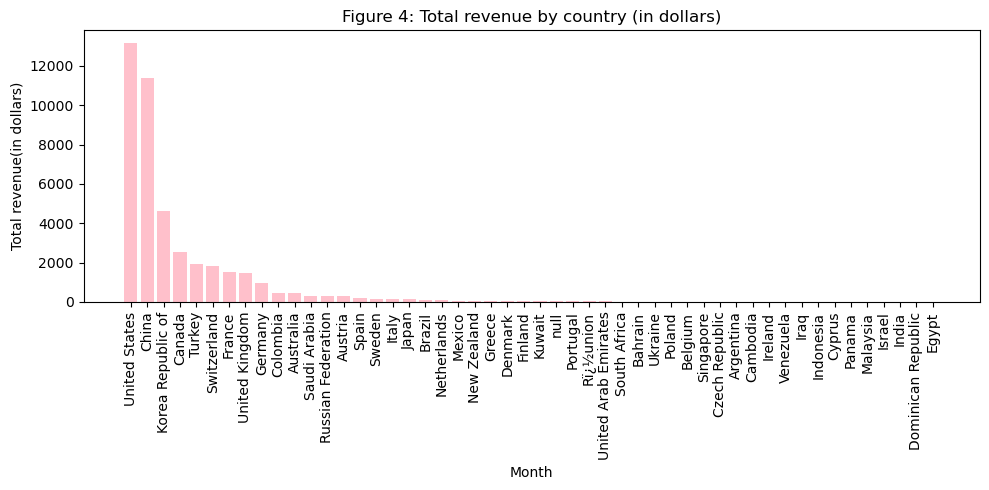

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

# Visualize Total revenue by country
ax.bar(country, revenue, color='pink')
ax.set_xlabel('Month')
ax.set_ylabel('Total revenue(in dollars)')
ax.set_title('Figure 4: Total revenue by country (in dollars)')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

In [29]:
# Word map visualization

cur.execute( '''
SELECT a.country_code as country, 
       SUM(i.iap_price_usd_cents) as total_usd_cents
FROM iap_purchase AS i 
JOIN account AS a ON a.account_id = i.account_id
GROUP BY country
ORDER BY total_usd_cents DESC;
''')

revenue_data_2 = cur.fetchall()
country_code, usd_cents = zip(*revenue_data_2)

revenue = [cents / 100 for cents in usd_cents]
country_code = [code.lower() for code in country_code if code is not None]


# World map object
worldmap = pygal.maps.world.World()
worldmap.title = 'Figure 5: Total revenue by country'

# List of tuples with country codes, revenue, and users
revenue_results = list(zip(country_code, revenue))

#Debug
#print(revenue_results)

# Add data to the map
worldmap.add('Total revenue', revenue_results)

# Render the map to an SVG file
worldmap.render_to_file('countries_map_total_revenue.svg')

![Alt text](countries_map_total_revenue.svg)

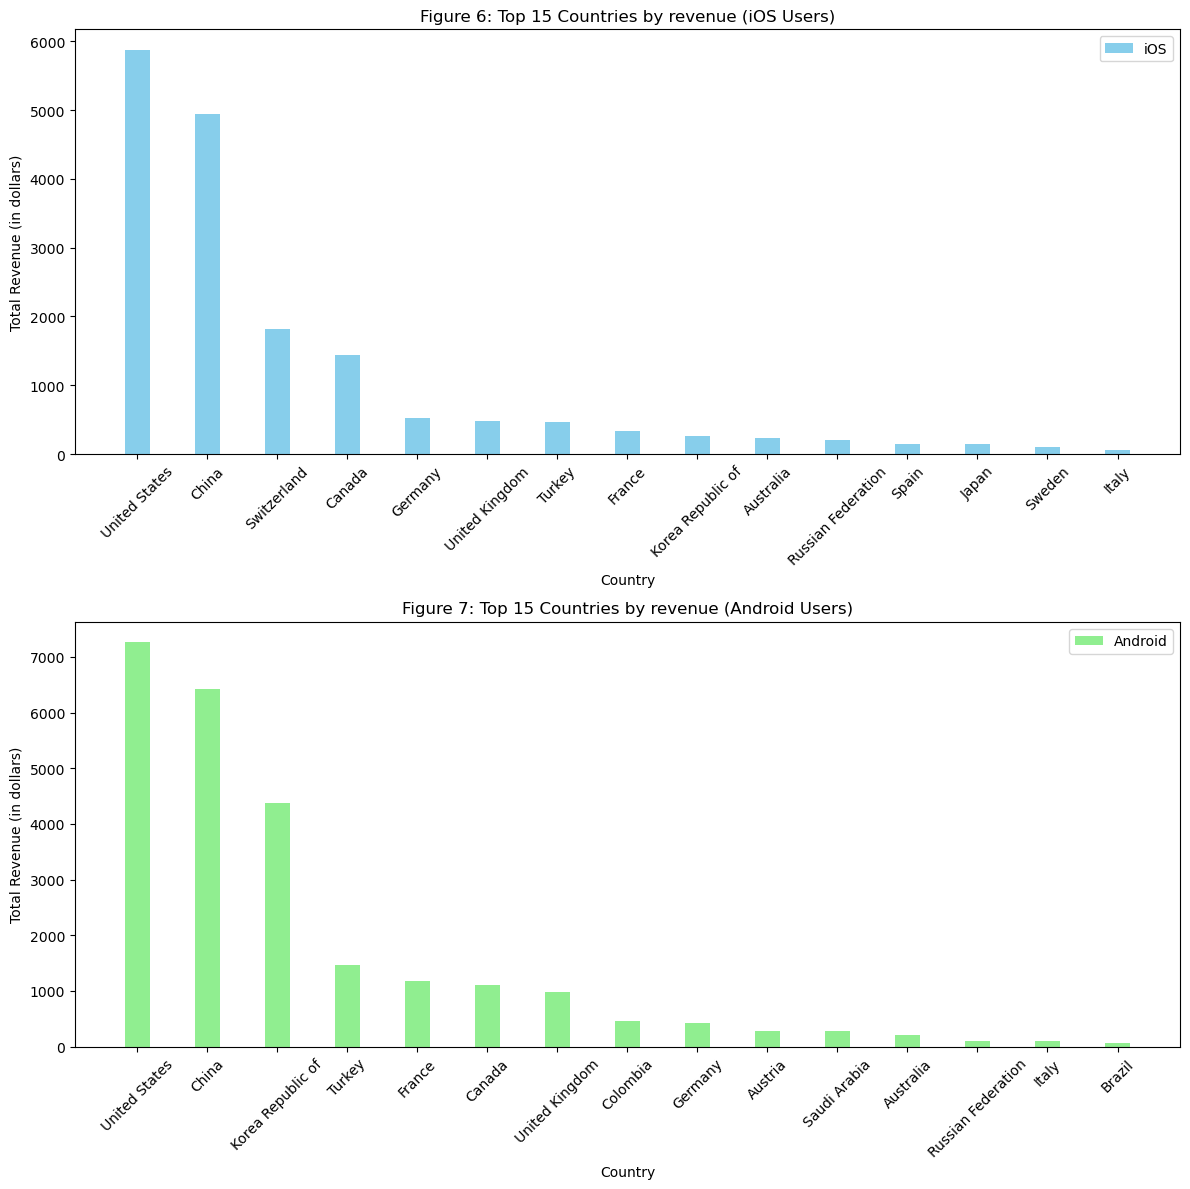

In [62]:
import matplotlib.pyplot as plt
import numpy as np
# Chart 1: total revenue - country
cur.execute( '''
    SELECT
        COALESCE(cm.country_name, 'null') AS country,
        SUM(CASE WHEN a.created_platform = 'iOS' THEN i.iap_price_usd_cents ELSE 0 END) AS ios_usd_cents,
        SUM(CASE WHEN a.created_platform = 'Android' THEN i.iap_price_usd_cents ELSE 0 END) AS android_usd_cents
    FROM
        iap_purchase AS i 
    JOIN
        account AS a ON a.account_id = i.account_id
    LEFT JOIN
        country_mappings AS cm ON a.country_code = cm.country_code
    GROUP BY
        country
    ORDER BY
        ios_usd_cents DESC, android_usd_cents DESC;
''')

revenue_data = cur.fetchall()
countries, ios_usd_cents, android_usd_cents = zip(*revenue_data)

# Convert cents to dollars
revenue_ios = [cents / 100 for cents in ios_usd_cents]
revenue_android = [cents / 100 for cents in android_usd_cents]

# Sort the data by iOS and Android revenue in descending order
sorted_ios_data = sorted(zip(countries, revenue_ios), key=lambda x: x[1], reverse=True)
sorted_android_data = sorted(zip(countries, revenue_android), key=lambda x: x[1], reverse=True)

# Extract the top 15 entries for iOS and Android
top_ios_countries, top_ios_revenue = zip(*sorted_ios_data[:15])
top_android_countries, top_android_revenue = zip(*sorted_android_data[:15])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

bar_width = 0.35
index_ios = np.arange(len(top_ios_countries))
index_android = np.arange(len(top_android_countries))

# Top 15 Countries revenue by -  iOS Users 
bar1 = ax1.bar(index_ios, top_ios_revenue, bar_width, label='iOS', color='skyblue')
ax1.set_xlabel('Country')
ax1.set_ylabel('Total Revenue (in dollars)')
ax1.set_title('Figure 6: Top 15 Countries by revenue (iOS Users)')
ax1.set_xticks(index_ios)
ax1.set_xticklabels(top_ios_countries)
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Top 15 Countries revenue by iOS Users 
bar2 = ax2.bar(index_android, top_android_revenue, bar_width, label='Android', color='lightgreen')
ax2.set_xlabel('Country')
ax2.set_ylabel('Total Revenue (in dollars)')
ax2.set_title('Figure 7: Top 15 Countries by revenue (Android Users)')
ax2.set_xticks(index_android)
ax2.set_xticklabels(top_android_countries)
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

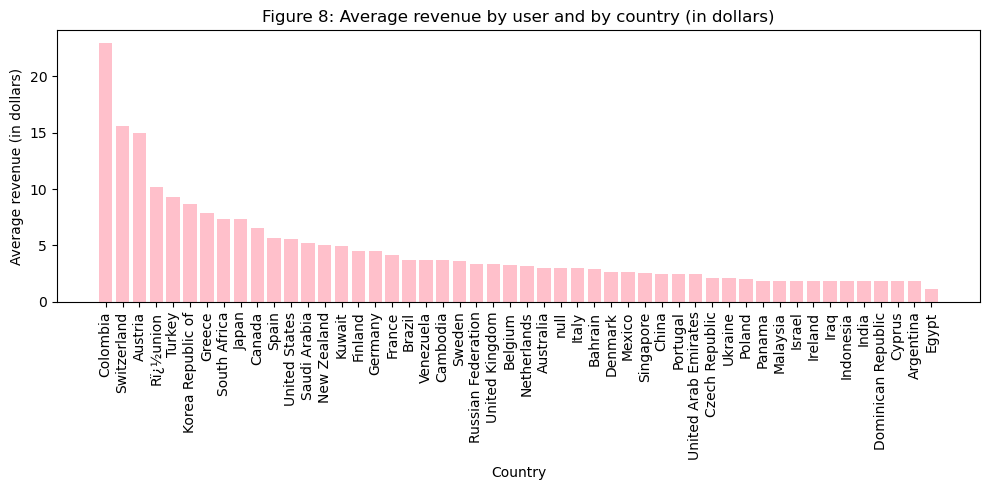

In [78]:
#Average revenue
cur.execute('''
    SELECT COALESCE(cm.country_name, 'null') AS country,
           AVG(i.iap_price_usd_cents) AS avg_usd_cents
    FROM iap_purchase AS i 
    JOIN account AS a ON a.account_id = i.account_id
    LEFT JOIN country_mappings AS cm ON a.country_code = cm.country_code
    GROUP BY country
    ORDER BY avg_usd_cents DESC;
''')

avg_revenue_data = cur.fetchall()
country, avg_usd_cents = zip(*avg_revenue_data)

avg_revenue = [cents / 100 for cents in avg_usd_cents]

fig, ax = plt.subplots(figsize=(10, 5))

# Average revenue by country chart
ax.bar(country, avg_revenue, color='pink')
ax.set_xlabel('Country')
ax.set_ylabel('Average revenue (in dollars)')
ax.set_title('Figure 8: Average revenue by user and by country (in dollars)')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

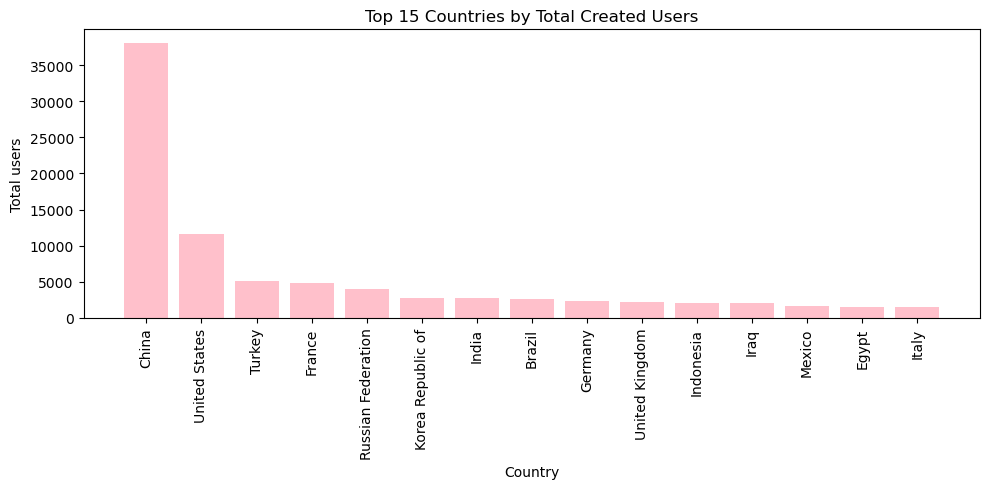

In [89]:
cur.execute('''
SELECT COALESCE(cm.country_name, 'null') AS country,
       COUNT(DISTINCT a.account_id) AS total_users
FROM account AS a
LEFT JOIN country_mappings AS cm ON a.country_code = cm.country_code
GROUP BY country
ORDER BY total_users DESC
LIMIT 15;
''')

users_data = cur.fetchall()
countries, total_users = zip(*users_data)

# Top 15 countries by total users
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(countries, total_users, color='pink')

ax.set_xlabel('Country')
ax.set_ylabel('Total users')
ax.set_title('Top 15 Countries by Total Created Users')

ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()


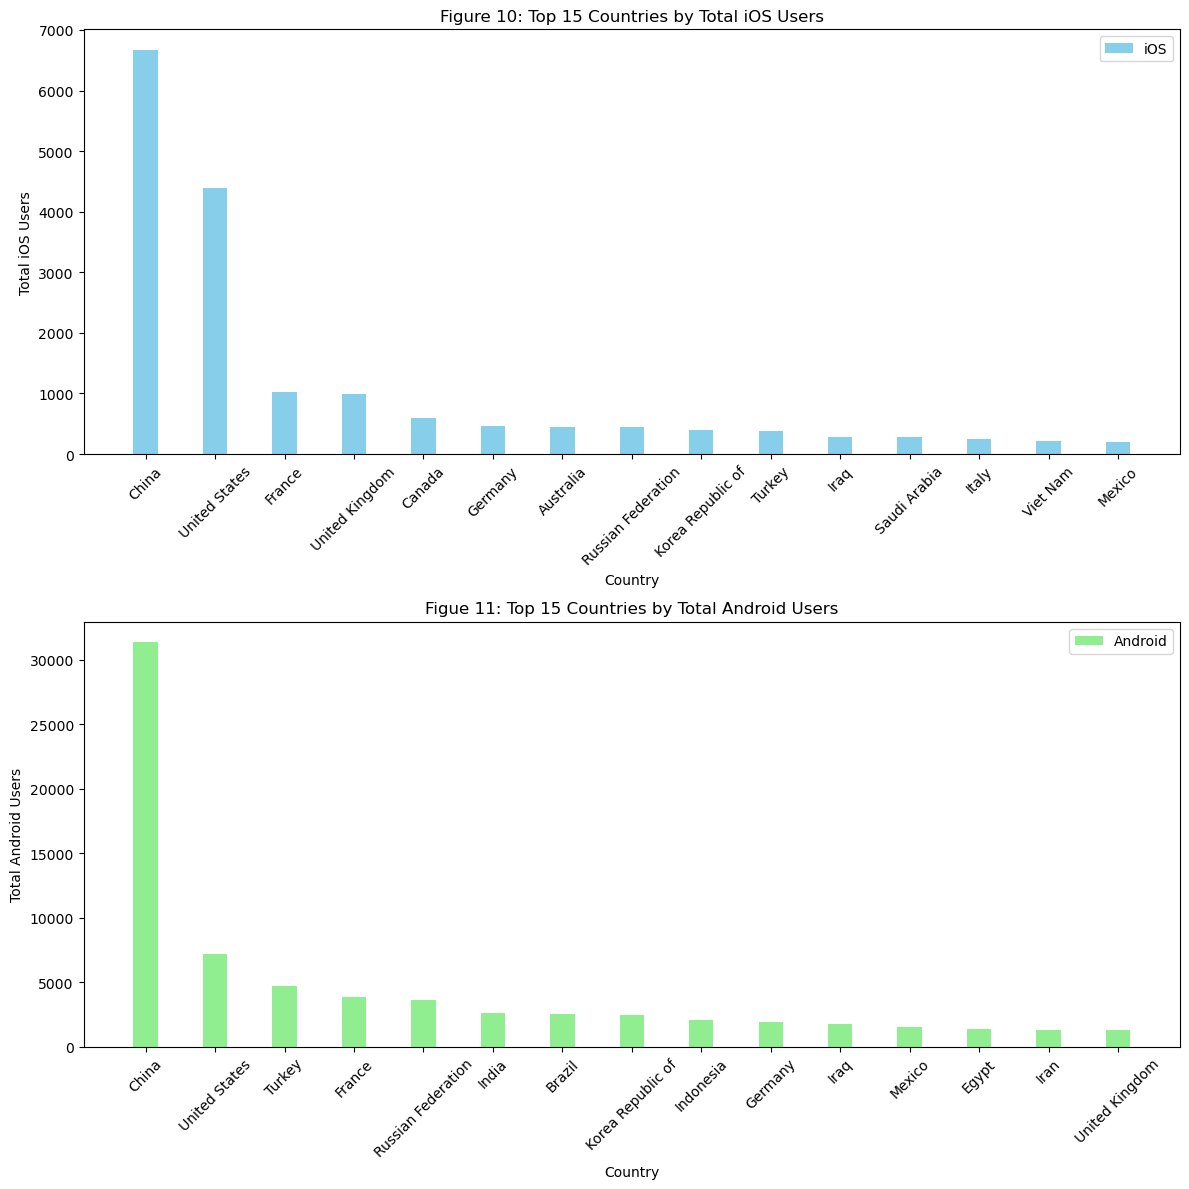

In [57]:
cur.execute( '''SELECT
    COALESCE(cm.country_name, 'null') AS country,
    COUNT(DISTINCT a.account_id) AS total_users,
    COUNT(DISTINCT CASE WHEN a.created_platform = 'iOS' THEN a.account_id END) AS ios_users,
    COUNT(DISTINCT CASE WHEN a.created_platform = 'Android' THEN a.account_id END) AS android_users
    FROM
        account AS a
    LEFT JOIN
        country_mappings AS cm ON a.country_code = cm.country_code
    GROUP BY
        country
    ORDER BY
        ios_users, ios_users DESC;''')

users_data = cur.fetchall()
countries, total_users, ios_users, android_users = zip(*users_data)

# Replace None values with 0 in ios_users and android_users
ios_users = [0 if user is None else user for user in ios_users]
android_users = [0 if user is None else user for user in android_users]

# Sort the data separately for iOS and Android in descending order
sorted_ios_data = sorted(zip(countries, total_users, ios_users, android_users), key=lambda x: x[2], reverse=True)
sorted_android_data = sorted(zip(countries, total_users, ios_users, android_users), key=lambda x: x[3], reverse=True)

# Extract the top 15 entries for iOS and Android separately
top_ios_data = sorted_ios_data[:15]
top_android_data = sorted_android_data[:15]

top_ios_countries, top_ios_total_users, top_ios_ios_users, top_ios_android_users = zip(*top_ios_data)
top_android_countries, top_android_total_users, top_android_ios_users, top_android_android_users = zip(*top_android_data)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

bar_width = 0.35
index = np.arange(len(top_ios_countries))

# Total iOS Users
bar1 = ax1.bar(index, top_ios_ios_users, bar_width, label='iOS', color='skyblue')
ax1.set_xlabel('Country')
ax1.set_ylabel('Total iOS Users')
ax1.set_title('Figure 10: Top 15 Countries by Total iOS Users')
ax1.set_xticks(index)
ax1.set_xticklabels(top_ios_countries)
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Total Android Users
bar2 = ax2.bar(index, top_android_android_users, bar_width, label='Android', color='lightgreen')
ax2.set_xlabel('Country')
ax2.set_ylabel('Total Android Users')
ax2.set_title('Figue 11: Top 15 Countries by Total Android Users')
ax2.set_xticks(index)
ax2.set_xticklabels(top_android_countries)
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

<a id='subsection-2.4'></a>
### Sales analysis: Comments
<br>
<div style="background-color: #FFFBF1; border-color: #FFFBF1; border-left: 5px solid #FFFBF1; padding: 0.5em;">

From the visualizations in sales analysis the following results can be extracted. As shown in the figure 3 the countries that has spent the most in the games are United States, China and Korea. In the worldmap it can be seen that, apart from the aforementioned countries, all Europe and a great part of South America are also a considerable source or revenue. There is almost no data in Africa, aside from Egypt and South Africa. The reason for this could be that no data has been recollected from those countries or that nobody in them has made any purchase. In the latter case it could be a potential market that could be explored to increase the revenue.
    
Regarding the average revenue per user (figure 8), it can be seen that the countries with a higher average revenue per user are Colombia, Switzerland and Austria. The latter two are wealthy countries, therefore it does make sense they consider spending more money, however further investigation should be done regarding the Colombia revenue per user to find new insights on why their average revenue per user is so high and what could be done to extrapolate those numbers to other countries. It might be that the game is culturally relevant to them, or there are items that resounds with this market the most.
    
Regarding the total users (figures 9, 10 and 11), it can be seen that China is by far the country with more users created for both platforms followed by United States. However, percentwise compared with their total population Turky and France are doing fairly well in comparison with other countries.
It is interesting that the US, with 30% more market share in iOS, loses to China in total users. But with a 70% market share for Android worldwide, it is not surprising that there 5 times more users in the Android platform than iOS. 
    
To analyse this in detail there should be a recollection of indicators of what items are working and which have a lesser revenue in each country to be able to try to reach new potential users and new markets.
    
</div>

<a id='section-3'></a>
# Behavioral segmentation model
Behavioural segmantation model is useful to create value and a more personsonalized experience for the user. With this data, there are 2 approaches we may consider: by user engagement or by monetization. A FRM analysis will be implemented to tackle first approach: monetization. However, it would be good to make a second analysis englobing user engagement too. The 3 measures of the RFM that I will take into account are:
<ul>
      <li><b>Recency:</b> amount of time since users last purchases</li>
    <li><b>Frequency:</b> number of times users have made a purchases</li>
    <li><b>Monetary:</b> how much money users have spent</li>
</ul>

These analysis will help us select some target customers groups from whom we can craft a personalized experience.

In [43]:
# Extract data

# I extract the necessary information regarding the purchases and interactions
# The databases are save in pandas dataframe for easy manipulation when building the model and training the model

df_p = pd.read_sql_query('''SELECT 
    iap_purchase.*, 
    account.created_platform, 
    account.country_code  
FROM 
    account
JOIN 
    iap_purchase ON account.account_id = iap_purchase.account_id;''', cnx)
df_p

,account_id,created_time,package_id_hash,iap_price_usd_cents,app_store_id,created_platform,country_code
0,13514010,2016-03-11 09:16:29.313,99a9e0e63efa2fdce8fc8de74c66cea9,184,0,iOS,GB
1,14894920,2016-06-29 14:47:41.68,efd2eebfdc98b55f9e6b45915d56f7ac,36,3,Android,CN
2,12365400,2016-09-16 13:08:40.206,efd2eebfdc98b55f9e6b45915d56f7ac,36,10,iOS,CN
3,12365400,2016-09-18 09:49:06.686,99a9e0e63efa2fdce8fc8de74c66cea9,184,10,iOS,CN
4,12365400,2016-09-20 07:49:32.397,99a9e0e63efa2fdce8fc8de74c66cea9,184,10,iOS,CN
...,...,...,...,...,...,...,...
9904,51551668381,2016-02-12 02:22:49.35,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0,iOS,KR
9905,51551668381,2016-02-15 17:56:59.299,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0,iOS,KR
9906,51551668381,2016-02-16 23:41:55.619,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0,iOS,KR
9907,51551668381,2016-03-09 06:23:09.672,99a9e0e63efa2fdce8fc8de74c66cea9,184,0,iOS,KR


In [44]:
# account_interactions = pd.read_sql_query("SELECT * FROM account_date_session", cnx)
# account_interactions

In [45]:
# By using the following query I can see what packages belong to which app
cur.execute( '''SELECT DISTINCT app_store_id, package_id_hash
FROM iap_purchase;''')

In [47]:
# Last date of package bought
last_timestamp = df_p['created_time'].max()
last_timestamp = pd.to_datetime(last_timestamp, format='%Y-%m-%d %H:%M:%S.%f')
print("Last Timestamp:", last_timestamp)

Last Timestamp: 2016-12-31 23:57:32.979000


In [81]:
df_p['created_time'] = pd.to_datetime(df_p['created_time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
df_p['recency'] = last_timestamp - df_p['created_time'] 
#print("First few created times:", df_p['recency'].head())
# r = df_p[['account_id', 'recency']]

In [80]:
# Recency (last puchase by user)
df_p['recency'] = (last_timestamp - df_p['created_time']).dt.days
r = df_p[['account_id', 'recency']]

r = df_p.groupby('account_id')['recency'].min().reset_index()

In [50]:
# Calculate Frequency (number of times each user has made a purchase)
freq = df_p.groupby('account_id')['created_time'].count()
f = pd.DataFrame(freq).reset_index()
f.rename(columns={'created_time': 'frequency'}, inplace=True)

In [51]:
# Calculate Monetary value (total amount by customer)
m = df_p.groupby('account_id')['iap_price_usd_cents'].sum()
m = m.to_frame(name='monetary_value') /100
m = pd.DataFrame(m).reset_index()

In [52]:
print("Duplicates in f:", f.duplicated('account_id').any())
print("Duplicates in m:", m.duplicated('account_id').any())
print("Duplicates in r:", r.duplicated('account_id').any())

print("Unique values in f:", f['account_id'].nunique())
print("Unique values in m:", m['account_id'].nunique())
print("Unique values in r:", r['account_id'].nunique())

Duplicates in f: False
Duplicates in m: False
Duplicates in r: False
Unique values in f: 1549
Unique values in m: 1549
Unique values in r: 1549


In [53]:
# RFM values
rfm_df = f.merge(m,on='account_id').merge(r,on='account_id')
rfm_df

,account_id,frequency,monetary_value,recency
0,12322622,5,3.28,363.0
1,12336472,23,181.07,64.0
2,12348106,5,11.05,362.0
3,12352080,1,1.84,342.0
4,12365400,11,17.28,63.0
...,...,...,...,...
1544,8606270064,8,33.22,30.0
1545,8606366720,3,14.77,23.0
1546,8606420372,1,1.10,17.0
1547,8606455880,7,4.74,3.0


In [54]:
from sklearn.preprocessing import StandardScaler

#Standarization of the data
rfm_data = rfm_df[['frequency', 'monetary_value', 'recency']]

scaler = StandardScaler()
std_data = scaler.fit_transform(rfm_data)
# New df with std data
std_rfm = pd.DataFrame(data=std_data, columns=['frequency', 'monetary_value', 'recency'])

# Concatenate the standardized data with account_id
# std_df = pd.concat([rfm_df['account_id'], std_df], axis=1)

In [530]:
X = std_rfm
y = rfm_df['account_id']

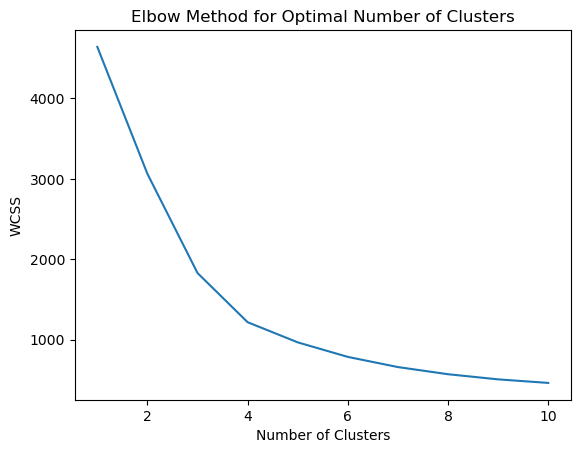

In [531]:
# Optimal number of clusters using the elbow method
def elbow_method(std_rfm):
    wcss = []  # Within-cluster sum of squares

    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(std_rfm)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

elbow_method(X)    

From here we can determine than an optimal number of cluster can 4 3 or 4.

In [532]:
# K-means algorithm
def kmeans_model(X, k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    
    labels = kmeans.labels_
    return kmeans, labels

In [533]:
labels = []
models = []
cluster_num_blobs = [3] # The numbers in the array are changed to try different numbers of clusters

for k in cluster_num_blobs:
    model, label = kmeans_model(X, k)
    labels.append(label)
    models.append(model)

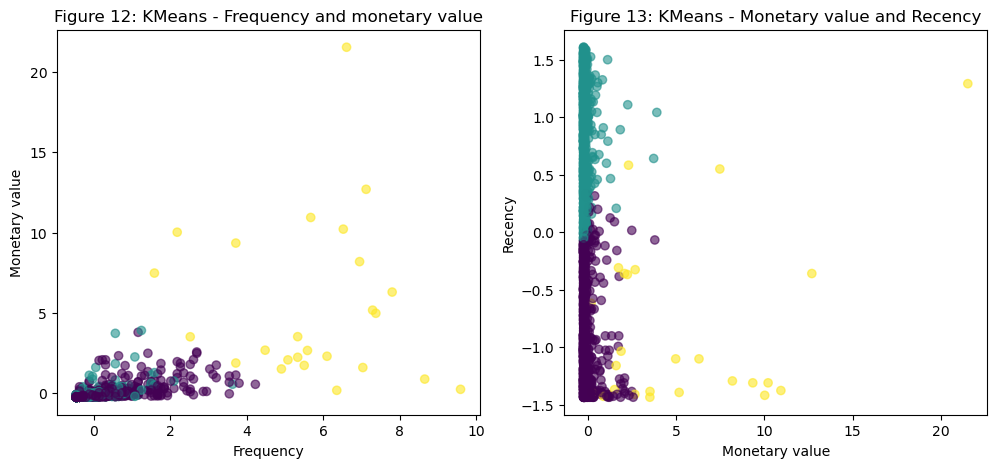

In [534]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot Frequency and monetary values
axes[0].scatter(X[:, 0], X[:, 1], c=labels[0], alpha=0.6)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Monetary value')
axes[0].set_title('Figure 12: KMeans - Frequency and monetary value')

# Plot Monetary value and Recency
axes[1].scatter(X[:, 1], X[:, 2], c=labels[0], alpha=0.6)
axes[1].set_xlabel('Monetary value')
axes[1].set_ylabel('Recency')
axes[1].set_title('Figure 13: KMeans - Monetary value and Recency')

plt.show()

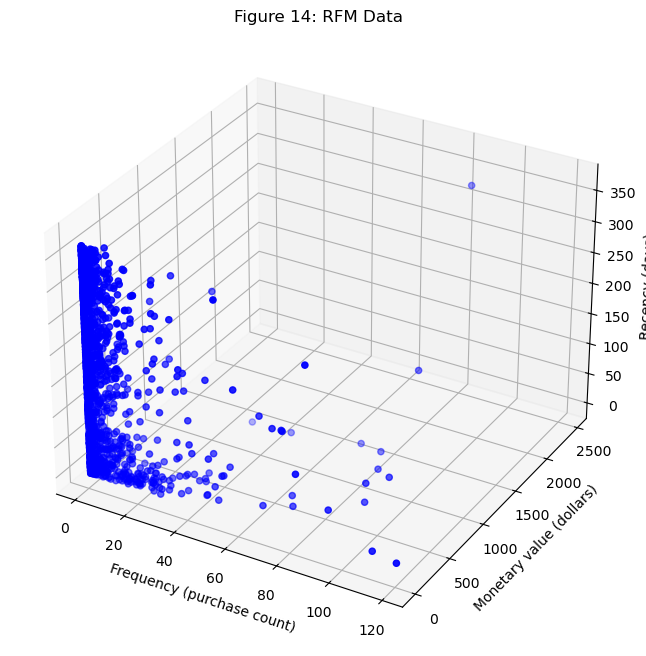

In [535]:
#Visualization of the scatter plot before applying K-means

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_df['frequency'], rfm_df['monetary_value'], rfm_df['recency'], c='blue', marker='o')

ax.set_xlabel('Frequency (purchase count)')
ax.set_ylabel('Monetary value (dollars)')
ax.set_zlabel('Recency (days)')

ax.set_title('Figure 14: RFM Data')

plt.show()

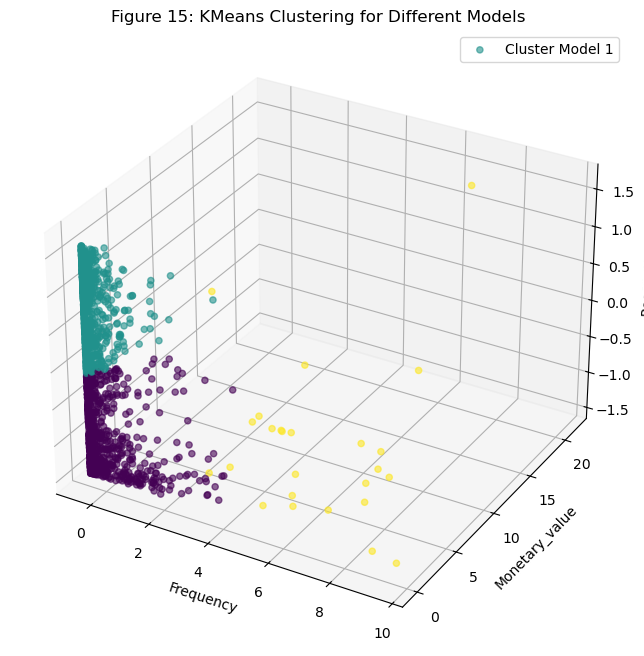

In [536]:
# 3D plot of the data labeled by clusters

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(labels):
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=label, label=f'Cluster Model {i + 1}', alpha=0.6)

ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary_value')
ax.set_zlabel('Recency')
ax.set_title('Figure 15: KMeans Clustering for Different Models')

ax.legend()

plt.show()

In [537]:
# Some numeric results of the clusters

unique_labels, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))

print("Cluster Sizes:")
for cluster, size in cluster_sizes.items():
    print(f"Cluster {cluster}: {size} data points")

kmeans_model, cluster_labels = kmeans_model(X, k=3)  # k=3
cluster_centers = kmeans_model.cluster_centers_

print("\nCluster Centroids (Means):")
for i, centroid in enumerate(cluster_centers):
    print(f"Cluster {i}: {centroid}")

Cluster Sizes:
Cluster 0: 744 data points
Cluster 1: 778 data points
Cluster 2: 25 data points

Cluster Centroids (Means):
Cluster 0: [ 0.07327809 -0.02893902 -0.89124701]
Cluster 1: [-0.24926383 -0.14204813  0.8789108 ]
Cluster 2: [ 5.80562823  5.50304204 -0.82556571]


In [90]:
#cur.close()
#cnx.close()

<a id='subsection-3.1'></a>
### Customer segmentation with FRM: Comments
<br>
<div style="background-color: #FFFBF1; border-color: #FFFBF1; border-left: 5px solid #FFFBF1; padding: 0.5em;">

A cluster segmentation has been created to have a more in-depth knowleadge of the users. All users that have purchased at least an item can be separated in 3 clusters:

<ul>
  <li><b>green cluster:(low frequency/ monetary value, high recency) </b>users that have made purchases recent and with low frequency and that the total amount spent is relatively small (less than 500 dollas)</li>
  <li><b>purple cluster(low frequency/ monetary/recency): </b>users that have not made any purchase recently, and the ones they have done are with a low frequency. Moreover, the total amount spent is relatively small.</li>
  <li><b>yellow cluster:</b>users that have spend from medium to a quite a significant amount of money (from 500 to 2500 dollars), and with a medium to high frequency (from 60 to 120 times), however most of them have not made any purchase recently.</li>
</ul>
  
Even though, the great majority of users belong to green and to the purple cluster, we should not disregard users from the yellow cluster. Even though there are fewer of them, they are the best users and also potential target customers to new games. The purple cluster indicate the customers that are at risk of not making more purchases or abandoning the apps. For this reason, incentivatization techniques should be applied and further investigation should be done to determine the reason for such low KPIs. And finally, the developers should enhance the experience of the users from the green cluster. They are the customers that have more recently made purcahses and they could be incentivized to spend more money in the future.
    
For this analysis 3 clusters were defined, for different customers with different needs. In short, most of the users from this app do not spend more than 500 dollas and have made purchases less than 20 times; and a more personal experience can be created for each of these user groups. 

</div>